In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import normflow_ds as nfds



In [2]:
ds = nfds.NormalizingFlowDynamicalSystem(dim=2, n_flows=3)


In [13]:
#for a batch of data
batch_size = 5
x_star = torch.zeros(batch_size, 2)
x_0 = torch.rand((batch_size, 2), requires_grad=True) * 10 - 5

In [14]:
#advance ds
T = 100
trajs = torch.zeros(batch_size, T, 2)
dt = 0.01

x = x_0
for i in range(T):
    x_dot = ds(x, x_star)
    trajs[:, i, :] = x
    x = x + x_dot*dt
    

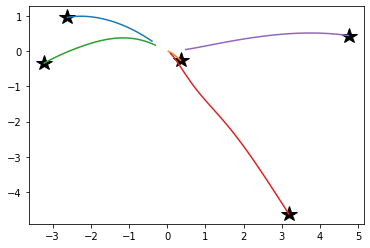

In [15]:
#plot trajs
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(batch_size):
    ax.plot([trajs[i, 0, 0].detach().numpy()],[trajs[i, 0, 1].detach().numpy()], '*k', markersize=16 )
    ax.plot(trajs[i, :, 0].detach().numpy(), trajs[i, :, 1].detach().numpy())

In [3]:
#flowchart
w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
x_grid = np.concatenate((X[:, :, np.newaxis],Y[:, :, np.newaxis]), -1)

x_pos = torch.from_numpy(x_grid.reshape(-1, 2))
x_pos = x_pos.float()
x_pos.requires_grad = True

# print(x_grid)
# print(x_grid-x_grid.reshape(-1, 2).reshape(10, 10, -1))

In [4]:
print(x_pos.shape)
x_pos_star = torch.zeros_like(x_pos)
print(x_pos_star.shape)
ds.init_phi()
x_dir = ds(x_pos, torch.zeros(x_pos.shape), inv=False)

torch.Size([10000, 2])
torch.Size([10000, 2])


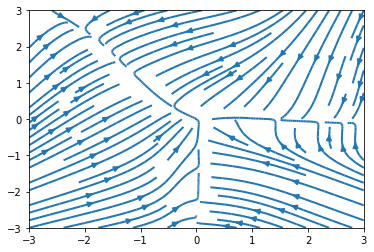

In [5]:
uv = x_dir.detach().numpy().reshape(100, 100, -1)
fig = plt.figure()
ax1 = fig.add_subplot(111)
strm = ax1.streamplot(X, Y, uv[:, :, 0], uv[:, :, 1], density=1, linewidth=2, cmap='autumn')


In [12]:
#try second order sys
ds = nfds.NormalizingFlowDynamicalSystem(dim=2, n_flows=3, D=1)
#for a batch of data
batch_size = 5
x_star = torch.zeros(batch_size, 2)
x_0 = torch.rand((batch_size, 2), requires_grad=True) * 10 - 5

x_dot_0 = (torch.rand((batch_size, 2), requires_grad=True) * 10 - 5) * 0.5



In [23]:
#advance ds
T = 1000
trajs = torch.zeros(batch_size, T, 2)
trajs_vel = torch.zeros(batch_size, T, 2)
dt = 0.01

noise_var = 0.5
x = x_0
x_dot = x_dot_0
for i in range(T):
    x_acc = ds.forward_with_damping(x, x_star, x_dot).detach()
    trajs[:, i, :] = x.detach()
    trajs_vel[:, i, :] = x_dot.detach()
    #generate noise to perturb x_acc
    x_perturb = torch.randn((batch_size, 2)) * noise_var
    x_perturb = ds.null_space_proj(x_perturb, x_dot)
    x_acc = (x_acc + x_perturb).detach()
#     print(torch.bmm(x_perturb.view(x_perturb.shape[0], 1, x_perturb.shape[1]), x_dot.view(x_dot.shape[0], x_dot.shape[1], 1)), )
    #semi-implicit integration
    x_dot = x_dot + (x_acc)*dt
    x = x + x_dot*dt
    

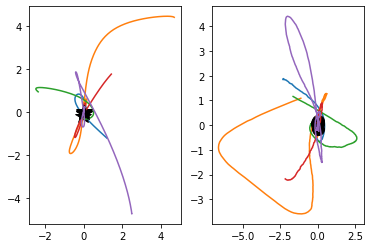

In [24]:
#plot trajs
fig = plt.figure()
ax = fig.add_subplot(121)
for i in range(batch_size):
    ax.plot([trajs[i, -1, 0].numpy()],[trajs[i, -1, 1].numpy()], '*k', markersize=16 )
    ax.plot(trajs[i, :, 0].numpy(), trajs[i, :, 1].numpy())
ax1 = fig.add_subplot(122)
for i in range(batch_size):
    ax1.plot([trajs_vel[i, -1, 0].numpy()],[trajs_vel[i, -1, 1].numpy()], 'ok', markersize=12 )
    ax1.plot(trajs_vel[i, :, 0].numpy(), trajs_vel[i, :, 1].numpy())